<a href="https://colab.research.google.com/github/beifa/Bengali.AI/blob/master/EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Github Tutorial](https://github.com/pytorch/ignite/blob/master/examples/notebooks/EfficientNet_Cifar100_finetuning.ipynb)

Network architecture review¶
The architecture of EfficientNet-B0 is the following:

1 - Stem 

            - Conv3x3|BN|Swish

2 - Blocks 
 - MBConv1, k3x3 
            - MBConv6, k3x3 repeated 2 times
            - MBConv6, k5x5 repeated 2 times
            - MBConv6, k3x3 repeated 3 times
            - MBConv6, k5x5 repeated 3 times
            - MBConv6, k5x5 repeated 4 times
            - MBConv6, k3x3
            
                                        totally 16 blocks

3 - Head    
            
            - Conv1x1|BN|Swish 
            - Pooling
            - Dropout
            - FC
where

Swish(x) = x * sigmoid(x)
and MBConvX stands for mobile inverted bottleneck convolution, X - denotes expansion ratio:

MBConv1 : 

  -> DepthwiseConv|BN|Swish -> SqueezeExcitation -> Conv|BN

MBConv6 : 

  -> Conv|BN|Swish -> DepthwiseConv|BN|Swish -> SqueezeExcitation -> Conv|BN

MBConv6+IdentitySkip : 

  -.-> Conv|BN|Swish -> DepthwiseConv|BN|Swish -> SqueezeExcitation 
-> Conv|BN-(+)->

In [0]:
!pip install pytorch-ignite

In [0]:
import random
import torch
import torch.nn as nn 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.nn import functional as F
from collections import OrderedDict
import math
%matplotlib inline



seed = 13
random.seed(seed)
_ = torch.manual_seed(seed)

torch.__version__

'1.4.0'

# Model

## Help modules

In [0]:
class Swish(nn.Module):

  def forward(self, x):
    return x * torch.sigmoid(x)

class Flatten(nn.Module):
  
  def forward(self, x):
    return x.reshape(x.shape[0], -1)

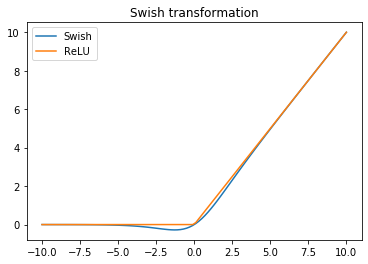

In [0]:
d = torch.linspace(-10.0, 10.0)
s = Swish()
res = s(d)
res2 = torch.relu(d)

plt.title("Swish transformation")
plt.plot(d.numpy(), res.numpy(), label='Swish')
plt.plot(d.numpy(), res2.numpy(), label='ReLU')
plt.legend()

## Model

In [0]:
class SqueezeExcitation(nn.Module):
    
  def __init__(self, inplanes, se_planes):
    super(SqueezeExcitation, self).__init__()
    self.reduce_expand = nn.Sequential(
      nn.Conv2d(inplanes, se_planes, 
                kernel_size=1, stride=1, padding=0, bias=True),
      Swish(),
      nn.Conv2d(se_planes, inplanes, 
                kernel_size=1, stride=1, padding=0, bias=True),
      nn.Sigmoid()
      )

  def forward(self, x):
    x_se = torch.mean(x, dim=(-2, -1), keepdim=True)
    x_se = self.reduce_expand(x_se)
    return x_se * x




class MBConv(nn.Module):

  def __init__(self, inplanes, planes, kernel_size, stride, 
                expand_rate=1.0, se_rate=0.25, 
                drop_connect_rate=0.2):
      super(MBConv, self).__init__()

      expand_planes = int(inplanes * expand_rate)
      se_planes = max(1, int(inplanes * se_rate))

      self.expansion_conv = None        
      if expand_rate > 1.0:
          self.expansion_conv = nn.Sequential(
              nn.Conv2d(inplanes, expand_planes, 
                        kernel_size=1, stride=1, padding=0, bias=False),
              nn.BatchNorm2d(expand_planes, momentum=0.01, eps=1e-3),
              Swish()
          )
          inplanes = expand_planes

      self.depthwise_conv = nn.Sequential(
          nn.Conv2d(inplanes, expand_planes,
                    kernel_size=kernel_size, stride=stride, 
                    padding=kernel_size // 2, groups=expand_planes,
                    bias=False),
          nn.BatchNorm2d(expand_planes, momentum=0.01, eps=1e-3),
          Swish()
      )

      self.squeeze_excitation = SqueezeExcitation(expand_planes, se_planes)
      
      self.project_conv = nn.Sequential(
          nn.Conv2d(expand_planes, planes, 
                    kernel_size=1, stride=1, padding=0, bias=False),
          nn.BatchNorm2d(planes, momentum=0.01, eps=1e-3),
      )

      self.with_skip = stride == 1
      self.drop_connect_rate = torch.tensor(drop_connect_rate, requires_grad=False)
  
  def _drop_connect(self, x):        
      keep_prob = 1.0 - self.drop_connect_rate
      drop_mask = torch.rand(x.shape[0], 1, 1, 1) + keep_prob
      drop_mask = drop_mask.type_as(x)
      drop_mask.floor_()
      return drop_mask * x / keep_prob
      
  def forward(self, x):
      z = x
      if self.expansion_conv is not None:
          x = self.expansion_conv(x)

      x = self.depthwise_conv(x)
      x = self.squeeze_excitation(x)
      x = self.project_conv(x)
      
      # Add identity skip
      if x.shape == z.shape and self.with_skip:            
          if self.training and self.drop_connect_rate is not None:
              self._drop_connect(x)
          x += z
      return x

def init_weights(module):    
    if isinstance(module, nn.Conv2d):    
        nn.init.kaiming_normal_(module.weight, a=0, mode='fan_out')
    elif isinstance(module, nn.Linear):
        init_range = 1.0 / math.sqrt(module.weight.shape[1])
        nn.init.uniform_(module.weight, a=-init_range, b=init_range)
        
        
class EfficientNet(nn.Module):
        
  def _setup_repeats(self, num_repeats):
      return int(math.ceil(self.depth_coefficient * num_repeats))
  
  def _setup_channels(self, num_channels):
      num_channels *= self.width_coefficient
      new_num_channels = math.floor(num_channels / self.divisor + 0.5) * self.divisor
      new_num_channels = max(self.divisor, new_num_channels)
      if new_num_channels < 0.9 * num_channels:
          new_num_channels += self.divisor
      return new_num_channels

  def __init__(self, num_classes=100, 
                width_coefficient=1.0,
                depth_coefficient=1.0,
                se_rate=0.25,
                dropout_rate=0.2,
                drop_connect_rate=0.2):
      super(EfficientNet, self).__init__()
      
      self.width_coefficient = width_coefficient
      self.depth_coefficient = depth_coefficient
      self.divisor = 8
              
      list_channels = [32, 16, 24, 40, 80, 112, 192, 320, 1280]
      list_channels = [self._setup_channels(c) for c in list_channels]
              
      list_num_repeats = [1, 2, 2, 3, 3, 4, 1]
      list_num_repeats = [self._setup_repeats(r) for r in list_num_repeats]        
      
      expand_rates = [1, 6, 6, 6, 6, 6, 6]
      strides = [1, 2, 2, 2, 1, 2, 1]
      kernel_sizes = [3, 3, 5, 3, 5, 5, 3]

      # Define stem:
      self.stem = nn.Sequential(
          nn.Conv2d(3, list_channels[0], kernel_size=3, stride=2, padding=1, bias=False),
          nn.BatchNorm2d(list_channels[0], momentum=0.01, eps=1e-3),
          Swish()
      )
      
      # Define MBConv blocks
      blocks = []
      counter = 0
      num_blocks = sum(list_num_repeats)
      for idx in range(7):
          
          num_channels = list_channels[idx]
          next_num_channels = list_channels[idx + 1]
          num_repeats = list_num_repeats[idx]
          expand_rate = expand_rates[idx]
          kernel_size = kernel_sizes[idx]
          stride = strides[idx]
          drop_rate = drop_connect_rate * counter / num_blocks
          
          name = "MBConv{}_{}".format(expand_rate, counter)
          blocks.append((
              name,
              MBConv(num_channels, next_num_channels, 
                      kernel_size=kernel_size, stride=stride, expand_rate=expand_rate, 
                      se_rate=se_rate, drop_connect_rate=drop_rate)
          ))
          counter += 1
          for i in range(1, num_repeats):                
              name = "MBConv{}_{}".format(expand_rate, counter)
              drop_rate = drop_connect_rate * counter / num_blocks                
              blocks.append((
                  name,
                  MBConv(next_num_channels, next_num_channels, 
                          kernel_size=kernel_size, stride=1, expand_rate=expand_rate, 
                          se_rate=se_rate, drop_connect_rate=drop_rate)                                    
              ))
              counter += 1
      
      self.blocks = nn.Sequential(OrderedDict(blocks))
      
      # Define head
      self.head = nn.Sequential(
          nn.Conv2d(list_channels[-2], list_channels[-1], 
                    kernel_size=1, bias=False),
          nn.BatchNorm2d(list_channels[-1], momentum=0.01, eps=1e-3),
          Swish(),
          nn.AdaptiveAvgPool2d(1),
          Flatten(),
          nn.Dropout(p=dropout_rate),
          nn.Linear(list_channels[-1], num_classes)
      )

      self.apply(init_weights)
      
  def forward(self, x):
      f = self.stem(x)
      f = self.blocks(f)
      #set_trace()
      y = self.head(f)
      f0 = nn.Sequential(nn.Linear(128, 11))
      f1 = nn.Sequential(nn.Linear(128, 168))
      f2 = nn.Sequential(nn.Linear(128, 7))
      
      return f0, f1, f2


All EfficientNet models can be defined using the following parametrization:

**(width_coefficient, depth_coefficient, resolution, dropout_rate)**

'efficientnet-b0': (1.0, 1.0, 224, 0.2),

'efficientnet-b1': (1.0, 1.1, 240, 0.2),

'efficientnet-b2': (1.1, 1.2, 260, 0.3),

'efficientnet-b3': (1.2, 1.4, 300, 0.3),

'efficientnet-b4': (1.4, 1.8, 380, 0.4),

'efficientnet-b5': (1.6, 2.2, 456, 0.4),

'efficientnet-b6': (1.8, 2.6, 528, 0.5),

'efficientnet-b7': (2.0, 3.1, 600, 0.5),

Let's define and train the third one: EfficientNet-B0

In [0]:
data = pd.read_feather('/content/drive/My Drive/Bengali/data/resize/train_data_0_42.feather')
train = pd.read_csv('/content/drive/My Drive/Bengali/data/train.csv')

In [0]:
model = EfficientNet(num_classes=1000, width_coefficient=1, depth_coefficient=1, dropout_rate=0.2)

In [0]:
!wget http://storage.googleapis.com/public-models/efficientnet-b0-08094119.pth

--2020-03-07 23:10:22--  http://storage.googleapis.com/public-models/efficientnet-b0-08094119.pth
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 2607:f8b0:400c:c15::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21383481 (20M) [application/octet-stream]
Saving to: ‘efficientnet-b0-08094119.pth.2’

efficientnet-b0-080 100%[===================>]  20.39M  74.4MB/s    in 0.3s    

2020-03-07 23:10:22 (74.4 MB/s) - ‘efficientnet-b0-08094119.pth.2’ saved [21383481/21383481]



In [0]:
model_state = torch.load("efficientnet-b0-08094119.pth") #return OrderDict
"""
 он помнит порядок, в котором ему были даны ключи
 OrderedDict([('_conv_stem.weight',
              tensor([[[[-4.4029e-01, -2.9288e-01,  2.7663e-02],
              .....
"""


# A basic remapping is required
mapping = {
    k: v for k, v in zip(model_state.keys(), model.state_dict().keys())
}
mapped_model_state = OrderedDict([
    (mapping[k], v) for k, v in model_state.items()
])

model.load_state_dict(mapped_model_state, strict=False)

<All keys matched successfully>

In [0]:
out = nn.Sequential(
    nn.Linear(in_features=1280, out_features = 11),
    nn.Linear(in_features=1280, out_features = 168),
    nn.Linear(in_features=1280, out_features = 7)
)

model.head[6] = out

In [0]:
from torch.utils.data import Dataset, DataLoader

class Data(Dataset):

  def __init__(self, data, label, transforms = None):
    self.data = data
    self.label = label
    self.transforms = transforms
  
  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    img = self.data.iloc[idx, 1:].values.reshape(42, 42).astype(np.uint8)       

    if self.transforms is not None:
                 
      img = self.transforms(img)

      
    img = np.repeat(img, 3, axis = 0)  

    lab1 = self.label.vowel_diacritic.values[idx]
    lab2 = self.label.grapheme_root.values[idx]
    lab3 = self.label.consonant_diacritic.values[idx]            
    
    return img, torch.tensor([lab1, lab2, lab3]) 

In [0]:
from torchvision.transforms import Compose, RandomCrop, Pad, RandomHorizontalFlip, Resize
from torchvision.transforms import ToTensor, Normalize, ToPILImage
import torchvision

from torch.utils.data import Subset
from PIL.Image import BICUBIC
from PIL import Image


tr =  Compose([
               ToPILImage(),
               Resize(256, BICUBIC),
               RandomCrop(224),
               RandomHorizontalFlip(),
               ToTensor(),
               Normalize(mean=[0.485,], std=[0.229,])
               
])


dataset = Data(data, train, transforms = tr)
dataloader = DataLoader(dataset, batch_size = 128, shuffle=True, drop_last=True, pin_memory=False)

In [0]:
img, _ = next(iter(dataloader))
plt.imshow(img[0][0])

In [0]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.8)
criterion = nn.CrossEntropyLoss()